# Describing a PIV evaluation using openPIV

[OpenPIV](https://github.com/OpenPIV/openpiv-python) is an open-source PIV software. Let's use it to process the PIV-Challenge recording
For this tutorial you need to have *openpiv* installed.

We will go through the steps of data retrieval and PIV evaluation. Then we will [describe those steps](#Describe-the-result-file)

Imports and required packages:

In [1]:
import pathlib
import zipfile

import cv2
import matplotlib.pyplot as plt
import numpy as np
import ontolutils
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ontolutils import M4I
from ontolutils.ex import prov
from openpiv import tools, pyprocess, validation, filters, scaling
from ssnolib import m4i

# !pip install openpiv
# !pip install opencv-python

In [2]:
import pivmetalib
from pivmetalib import pivmeta
from pivmetalib.namespace import PIV as PIVMETA

## Get image filenames

We can make make use of the PIV Dataset stored as a JSON-LD file:

In [3]:
image_dists = ontolutils.query(pivmeta.ImageVelocimetryDistribution, source='piv_challenge.jsonld', )
image_dist = image_dists[0]
image_dist

ImageVelocimetryDistribution(id=https://example.org/N591486144cab445b844164a224ef363e, title=Raw piv image data, downloadURL=https://www.pivchallenge.org/pub/C/C.zip, accessURL=https://www.pivchallenge.org/pub, mediaType=https://www.iana.org/assignments/media-types/image/tiff, filenamePattern=C[0-9][0-9][0-9]_[1,2].tif, hasMetric=NumericalVariable(id=https://example.org/N8cf5b302285f4cf7852defb9ccaa54fd, label=bit depth, hasNumericalValue=8, @type=http://w3id.org/nfdi4ing/metadata4ing#NumericalVariable))

The PIV dataset description tells us where and how to download the file:

In [4]:
zip_filename = image_dist.download()
zip_filename

WindowsPath('C:/Users/matth/Documents/GitHub/pivmetalib/docs/C.zip')

Unzip the files:

In [5]:
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('imgs')

Get filenames based on filename pattern:

In [6]:
image_dist.filenamePattern

'C[0-9][0-9][0-9]_[1,2].tif'

In [7]:
filenames = sorted(pathlib.Path('imgs').glob(image_dist.filenamePattern))  #image_dist.filenamePattern))
filenames

[WindowsPath('imgs/C001_1.tif'), WindowsPath('imgs/C001_2.tif')]

The same JSON-LD also tells us where to find the mask file:

In [8]:
mask_dist = pivmeta.ImageVelocimetryDistribution.from_jsonld(source='piv_challenge.jsonld', limit=None)
print(mask_dist[1].serialize("ttl"))  # let's have a look at one of it

@prefix dcat: <http://www.w3.org/ns/dcat#> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix piv: <https://matthiasprobst.github.io/pivmeta#> .

<https://example.org/N1d34cd48cb6541028b2ec79343f467d8> a piv:ImageVelocimetryDistribution ;
    dcterms:title "Mask file" ;
    dcat:accessURL <https://www.pivchallenge.org/pub> ;
    dcat:downloadURL <https://www.pivchallenge.org/pub/C/C.zip> ;
    dcat:mediaType <https://www.iana.org/assignments/media-types/image/tiff> .




Since it is in the same Zip, file, we can simply go in the already downloaded an unzipped folder:

In [9]:
mask_filename = sorted(pathlib.Path('imgs').glob(mask_dist[0].filenamePattern))
mask_filename

[WindowsPath('imgs/C001_1.tif'), WindowsPath('imgs/C001_2.tif')]

## Perform evaluation with OpenPIV

To perform the PIV evaluation, we'll be re-using code from [openpiv's tutorial 1](https://nbviewer.org/github/OpenPIV/openpiv-python-examples/blob/main/notebooks/tutorial1.ipynb):

In [10]:
frame_a = cv2.imread(str(filenames[0]), -1)
frame_b = cv2.imread(str(filenames[1]), -1)

# mask images
image_mask = cv2.imread(str(mask_filename), -1)
frame_a_masked = np.where(image_mask, frame_a, 0)
frame_b_masked = np.where(image_mask, frame_b, 0)

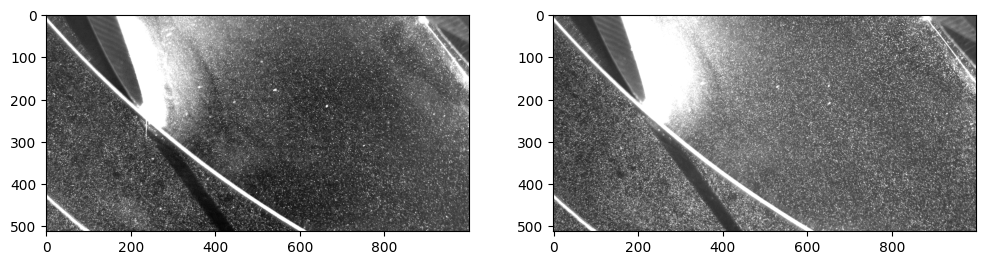

In [11]:
fig, _axs = plt.subplots(1, 2, figsize=(12, 10))
axs = _axs.ravel()
axs[0].imshow(frame_a, cmap=plt.cm.gray)
axs[1].imshow(frame_b, cmap=plt.cm.gray)
# axs[2].imshow(frame_a_masked, cmap=plt.cm.gray)
# axs[3].imshow(frame_b_masked, cmap=plt.cm.gray)

In [12]:
winsize = 32  # pixels, interrogation window size in frame A
searchsize = 38  # pixels, search in image B
overlap = 12  # pixels, 50% overlap
dt = 1  # sec, arbitrary here as we have no information

u0, v0, sig2noise = pyprocess.extended_search_area_piv(frame_a.astype(np.int32),
                                                       frame_b.astype(np.int32),
                                                       window_size=winsize,
                                                       overlap=overlap,
                                                       dt=dt,
                                                       search_area_size=searchsize,
                                                       sig2noise_method='peak2peak')



In [13]:
x, y = pyprocess.get_coordinates(image_size=frame_a.shape,
                                 search_area_size=searchsize,
                                 overlap=overlap)

In [14]:
flags = validation.sig2noise_val(sig2noise,
                                 threshold=1.05)

In [15]:
# filter out outliers that are very different from the
# neighbours
u2, v2 = filters.replace_outliers(u0, v0,
                                  flags,
                                  method='localmean',
                                  max_iter=3,
                                  kernel_size=3)

In [16]:
# convert x,y to mm
# convert u,v to mm/sec

x, y, u3, v3 = scaling.uniform(x, y, u2, v2,
                               scaling_factor=1)  # 1 microns/pixel (arbitrary, no info)

# 0,0 shall be bottom left, positive rotation rate is counterclockwise
x, y, u3, v3 = tools.transform_coordinates(x, y, u3, v3)

In [17]:
#save in the simple ASCII table format
tools.save('exp1_001.txt', x, y, u3, v3, flags=flags)

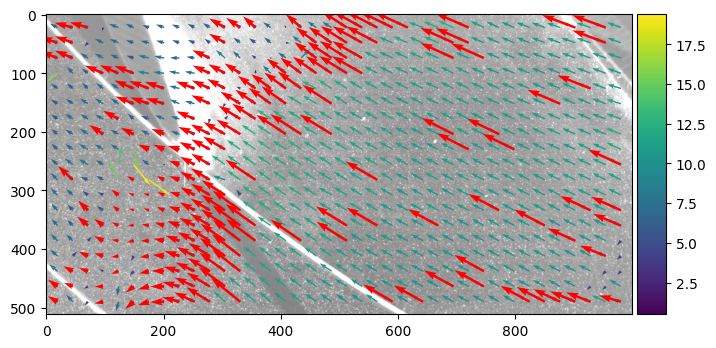

In [18]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(frame_a, cmap=plt.cm.gray, alpha=0.5)

v_abs = np.sqrt(u3 ** 2 + v3 ** 2)

plt.rcParams['image.cmap'] = 'viridis'

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

q = ax.quiver(x, y, u3, v3, v_abs)
ax.quiver(x[flags], y[flags], u3[flags], v3[flags], color='r', label='invalid')
plt.colorbar(q, cax=cax)

## Describe the result file

Firstly, we need to describe the software that was used:

In [19]:
software = pivmeta.PIVSoftware(
    id="https://github.com/OpenPIV/openpiv-python/releases/tag/v0.25.0",
    author=prov.Organization(
        name='OpenPIV',
        url='https://github.com/OpenPIV/openpiv-python',
    ),
    description='OpenPIV is an open source Particle Image Velocimetry analysis software written in Python and Cython',
    softwareVersion='0.25.0',  #openpiv.__version__,
    has_documentation='https://openpiv.readthedocs.io/en/latest/',
)

In [20]:
result_distribution = pivmeta.ImageVelocimetryDistribution(
    downloadURL=pathlib.Path('exp1_001.txt'),
    hasPIVDataType=PIVMETA.ResultData
)

Let's provide a minimal description of the PIV evaluation step:

The main evaluation step was a single pass method with an interrogation window size of 32px. It resulted in the exp1_001.txt file:

In [21]:
single_pass = pivmeta.Singlepass(
    parameter=m4i.NumericalVariable(
        label='interrogation window size',
        value=32,
        unit="px")
)

In [22]:
piv_eval = pivmeta.PIVEvaluation(
    hasOutput=result_distribution.id,
    hasEmployedTool=software,
    realizesMethod=single_pass
)

Add everything together and describe the Dataset:

In [32]:
from ontolutils.ex.prov import Attribution

In [33]:
result_dataset = pivmetalib.pivmeta.ImageVelocimetryDataset(
    distribution=result_distribution,
    hasPart=piv_eval,
    qualifiedAttribution=Attribution(
        agent=prov.Person(firstName='Matthias'),
        hadRole=M4I.Researcher
    )
)

In [35]:
print(result_dataset.serialize("ttl"))

@prefix dcat: <http://www.w3.org/ns/dcat#> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix foaf: <http://xmlns.com/foaf/0.1/> .
@prefix m4i: <http://w3id.org/nfdi4ing/metadata4ing#> .
@prefix pivmeta: <https://matthiasprobst.github.io/pivmeta#> .
@prefix prov: <http://www.w3.org/ns/prov#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix schema: <https://schema.org/> .
@prefix sd: <https://w3id.org/okn/o/sd#> .

<https://github.com/OpenPIV/openpiv-python/releases/tag/v0.25.0> a pivmeta:PIVSoftware ;
    dcterms:description "OpenPIV is an open source Particle Image Velocimetry analysis software written in Python and Cython" ;
    schema:author [ a prov:Organization ;
            foaf:name "OpenPIV" ;
            schema:url <https://github.com/OpenPIV/openpiv-python> ] ;
    schema:softwareVersion "0.25.0" ;
    sd:hasDocumentation <https://openpiv.readthedocs.io/en/latest/> .

[] a pivmeta:ImageVelocimetryDataset ;
    dcterms:hasPart [ a pivmeta:PIVEvaluation ;